In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_color_z = pd.read_csv(os.path.join(folder_path, "features_color_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_color_mm = pd.read_csv(os.path.join(folder_path, "features_color_all_minmax.csv"))

In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_color_z_cl= df_color_z.drop(columns=['filename', 'label'])

se va a buscar el que podría ser el mejor numero de clusteres usando BIC (Bayesian Information Criterion) y AIC (Akaike Information Criterion)

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

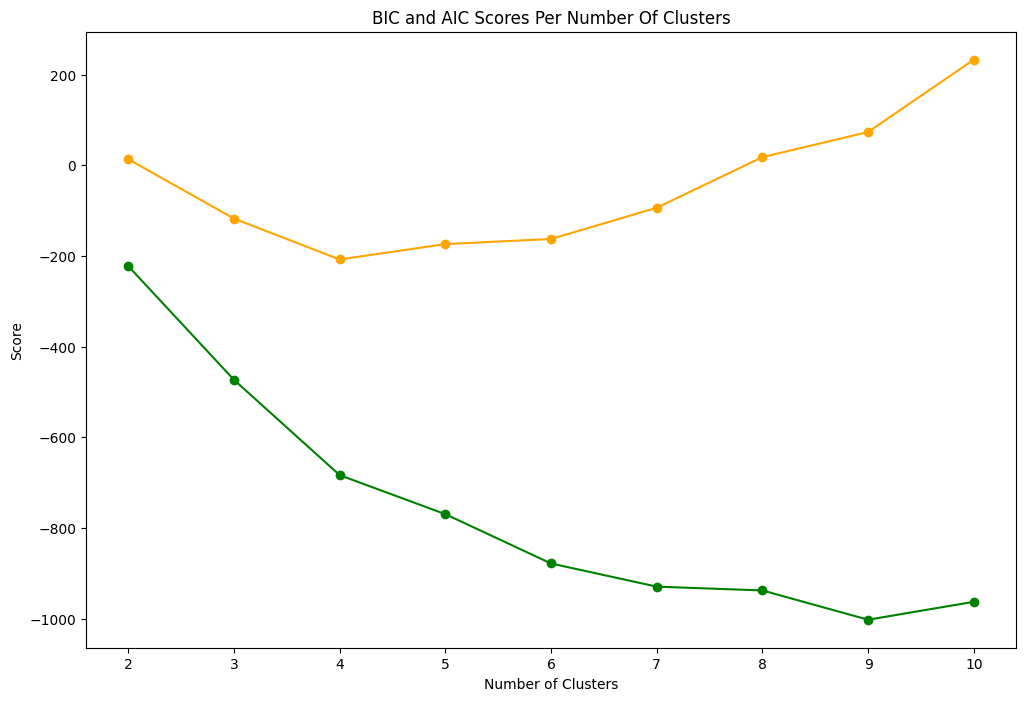

In [4]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_color_z_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_color_z_cl))
    aic_score.append(gm.aic(df_color_z_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')



In [5]:
n_components = 4  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_z = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_z.items():
    gmm_model.fit(df_color_z_cl)

In [6]:
covariances_z = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_z.items()}

In [7]:
predictions_z = {cov_type: gmm_model.predict(df_color_z_cl)
               for cov_type, gmm_model in gmm_models_z.items()}

Covariance Matrix (full - Component):
[[ 1.14295943  1.10437962  0.97049834  0.08453438 -0.58979639  1.1494526 ]
 [ 1.10437962  1.11677503  0.96876789  0.27581049 -0.58996935  1.13814797]
 [ 0.97049834  0.96876789  0.98335914  0.19781593 -0.76057732  0.98977408]
 [ 0.08453438  0.27581049  0.19781593  1.79476772 -0.07063124  0.24989223]
 [-0.58979639 -0.58996935 -0.76057732 -0.07063124  0.78140842 -0.59408841]
 [ 1.1494526   1.13814797  0.98977408  0.24989223 -0.59408841  1.17482591]]
Covariance Matrix (tied - Component):
[ 0.68054931  0.65694659  0.56794407  0.04271681 -0.37959232  0.68507331]
Covariance Matrix (diag - Component):
[0.08699434 0.06767234 0.18224511 0.93603034 0.34734472 0.06685095]
Covariance Matrix (spherical - Component):
0.26455508808501665


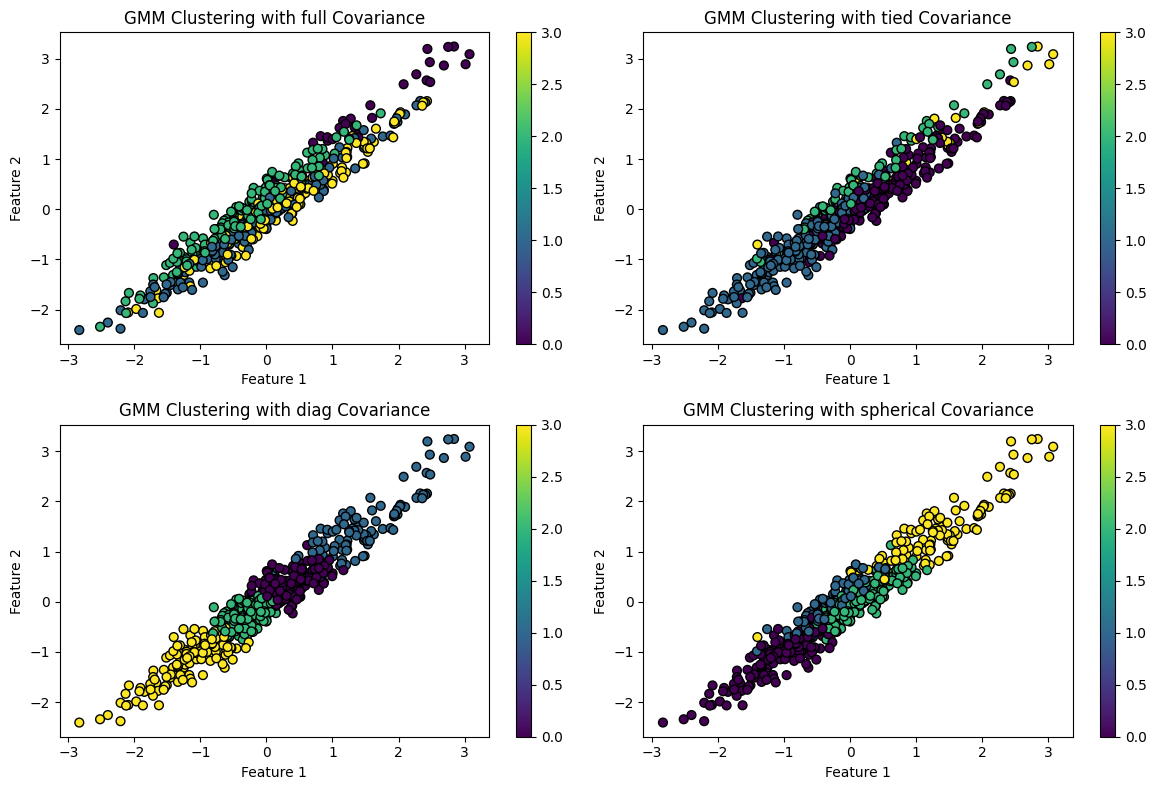

In [8]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_color_z_cl.iloc[:, 0], df_color_z_cl.iloc[:, 1], c=predictions_z[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_z[cov_type][0]}')

plt.tight_layout()
plt.show()

In [9]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_color_z_cl, predictions_z[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.093
Tied covariance: Silhouette Score = 0.170
Diag covariance: Silhouette Score = 0.214
Spherical covariance: Silhouette Score = 0.324


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


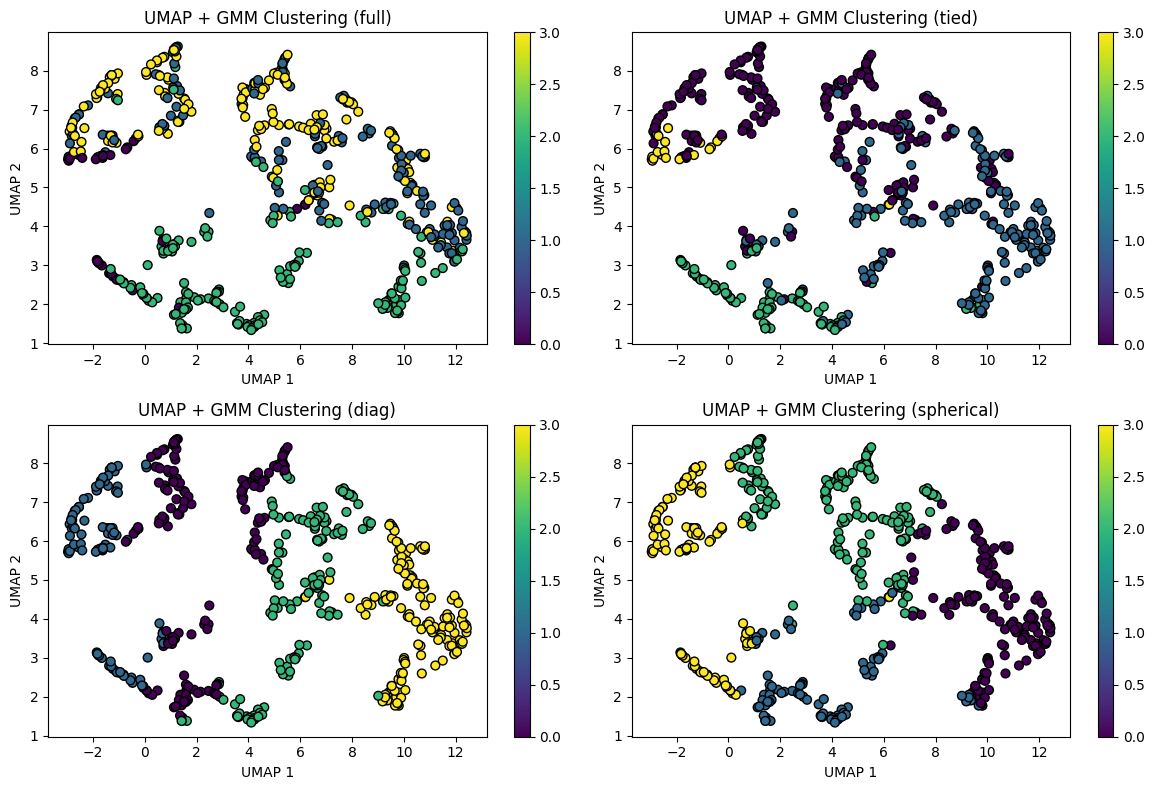

In [10]:
reducer = umap.UMAP(n_neighbors=9, n_components=2,random_state=42)
embedding = reducer.fit_transform(df_color_z_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_z[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()




In [11]:

df_color_z['predictions_z_full'] = predictions_z['full']
df_color_z['predictions_z_tied'] = predictions_z['tied']
df_color_z['predictions_z_diag'] = predictions_z['diag']
df_color_z['predictions_z_spherical'] = predictions_z['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_color_z['label'], df_color_z['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_color_z['label'], df_color_z['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_color_z['label'], df_color_z['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_color_z['label'], df_color_z['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)   0    1   2    3
Label                           
higher           2  100  90   76
smaller         33   49  79  108

Contingency Table for Tied Covariance:
Cluster (tied)    0    1   2   3
Label                           
higher          106  138  24   0
smaller         140   45  59  25

Contingency Table for Diagonal Covariance:
Cluster (diag)   0   1   2   3
Label                         
higher          83  36  65  84
smaller         80  60  74  55

Contingency Table for Spherical Covariance:
Cluster (spherical)   0   1   2   3
Label                              
higher               90  42  92  44
smaller              58  55  86  70


minmax

In [12]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_color_mm_cl= df_color_mm.drop(columns=['filename', 'label'])

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

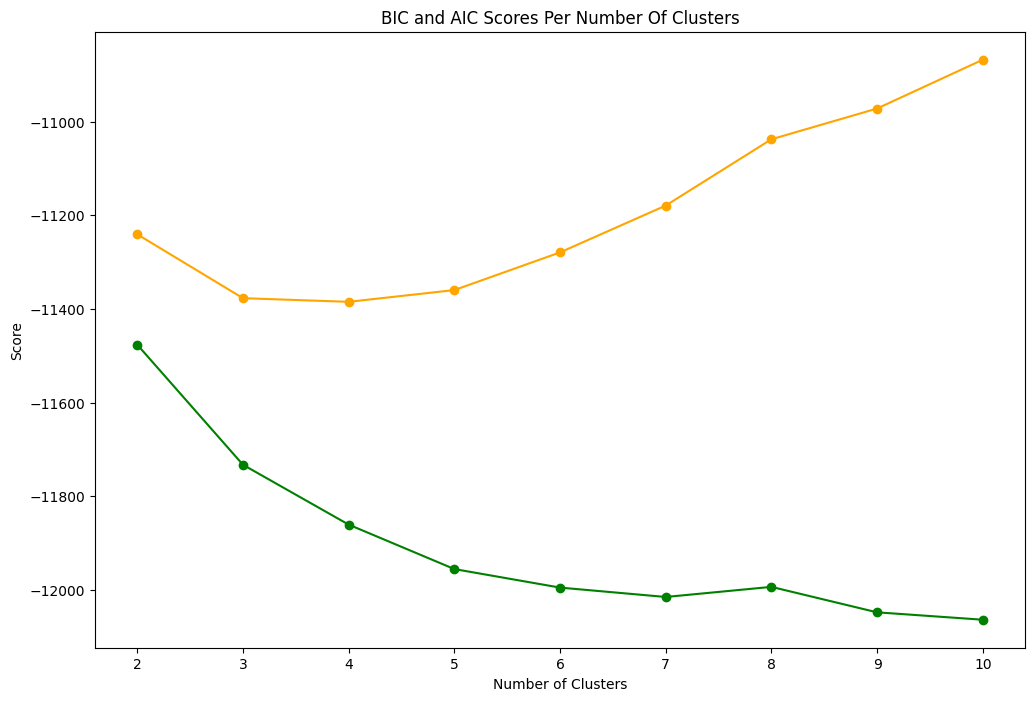

In [13]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_color_mm_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_color_mm_cl))
    aic_score.append(gm.aic(df_color_mm_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [14]:
n_components = 4  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_mm = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_mm.items():
    gmm_model.fit(df_color_mm_cl)


In [15]:
covariances_mm = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_mm.items()}

In [16]:
predictions_mm = {cov_type: gmm_model.predict(df_color_mm_cl)
               for cov_type, gmm_model in gmm_models_mm.items()}

Covariance Matrix (full - Component):
[[ 0.01779415  0.01875609  0.0147633   0.00486741 -0.01026738  0.01868747]
 [ 0.01875609  0.02073024  0.01639972  0.00709396 -0.01194995  0.01992156]
 [ 0.0147633   0.01639972  0.01606009  0.01054427 -0.01268595  0.01603315]
 [ 0.00486741  0.00709396  0.01054427  0.01630209 -0.00998526  0.00629672]
 [-0.01026738 -0.01194995 -0.01268595 -0.00998526  0.01205181 -0.01121513]
 [ 0.01868747  0.01992156  0.01603315  0.00629672 -0.01121513  0.01976551]]
Covariance Matrix (tied - Component):
[ 0.01952769  0.01972414  0.01657117  0.00129313 -0.01065419  0.02011559]
Covariance Matrix (diag - Component):
[0.00249739 0.00212458 0.00538688 0.03045852 0.00943792 0.00201212]
Covariance Matrix (spherical - Component):
0.024312390754519395


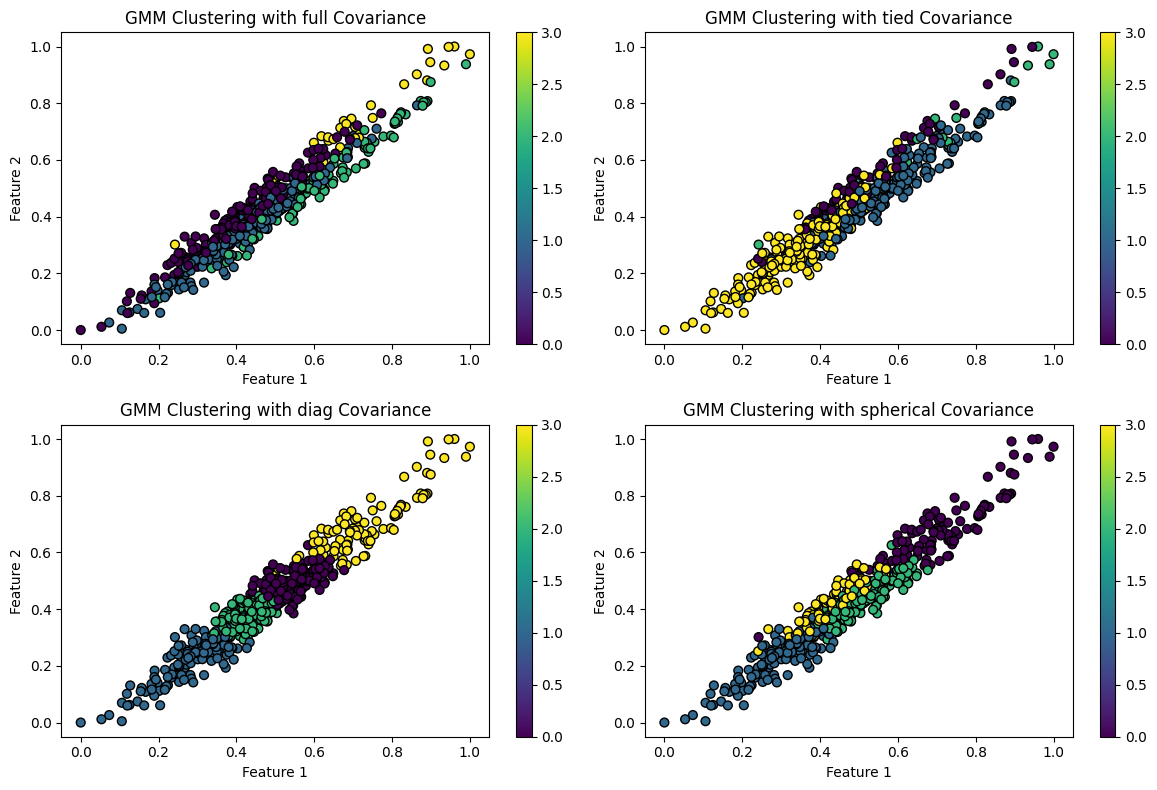

In [17]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_color_mm_cl.iloc[:, 0], df_color_mm_cl.iloc[:, 1], c=predictions_mm[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_mm[cov_type][0]}')

plt.tight_layout()
plt.show()

In [18]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_color_mm_cl, predictions_mm[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.127
Tied covariance: Silhouette Score = 0.177
Diag covariance: Silhouette Score = 0.213
Spherical covariance: Silhouette Score = 0.327


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


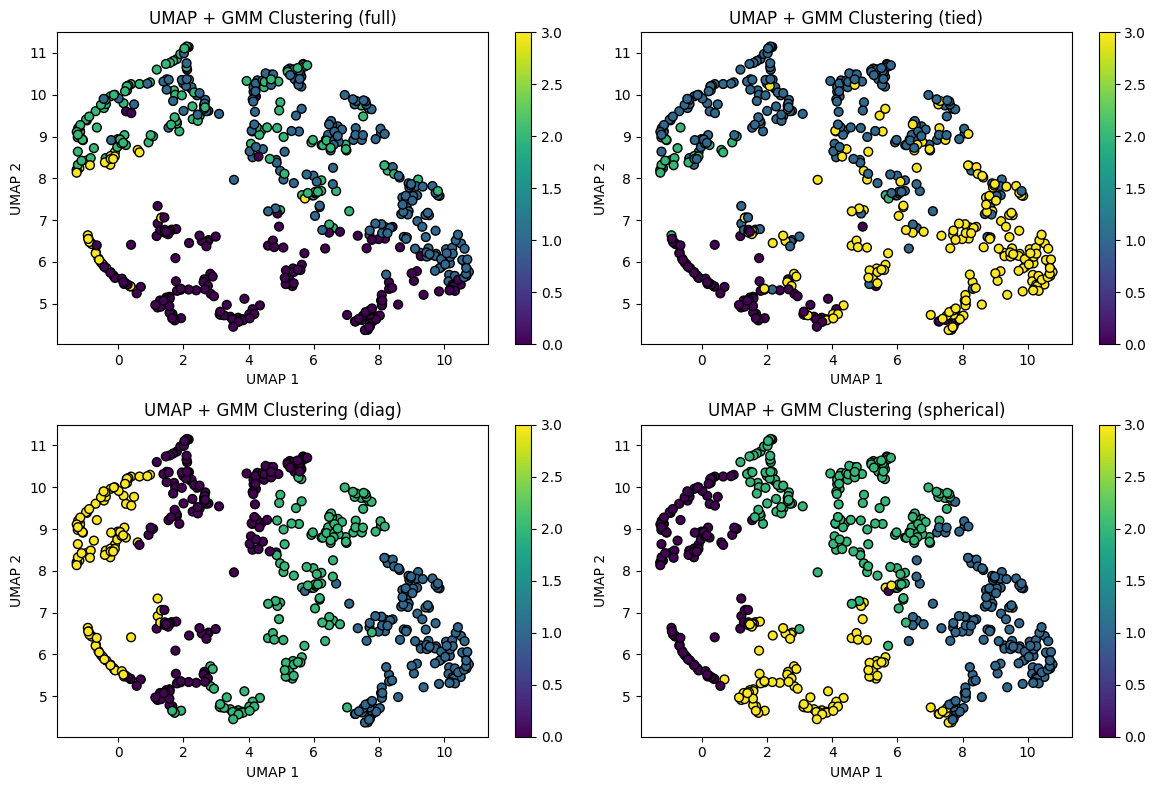

In [19]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
embedding = reducer.fit_transform(df_color_mm_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_mm[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [20]:
df_color_mm['predictions_z_full'] = predictions_mm['full']
df_color_mm['predictions_z_tied'] = predictions_mm['tied']
df_color_mm['predictions_z_diag'] = predictions_mm['diag']
df_color_mm['predictions_z_spherical'] = predictions_mm['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_color_mm['label'], df_color_mm['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_color_mm['label'], df_color_mm['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_color_mm['label'], df_color_mm['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_color_mm['label'], df_color_mm['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)   0    1   2   3
Label                          
higher          89  136  41   2
smaller         76   68  95  30

Contingency Table for Tied Covariance:
Cluster (tied)   0    1   2    3
Label                           
higher          25  105   0  138
smaller         59  139  25   46

Contingency Table for Diagonal Covariance:
Cluster (diag)   0   1   2   3
Label                         
higher          83  84  65  36
smaller         80  55  74  60

Contingency Table for Spherical Covariance:
Cluster (spherical)   0   1   2   3
Label                              
higher               43  90  93  42
smaller              70  59  86  54


reduccion de la dimensionalidad con umap y aplicar el clustering otra vez

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Covariance Matrix (full - Component 0):
[[1.75727139 0.66489183]
 [0.66489183 0.62638176]]
Covariance Matrix (tied - Component 0):
[ 2.26872392e+00 -1.13252179e-03]
Covariance Matrix (diag - Component 0):
[2.08901573 0.64012856]
Covariance Matrix (spherical - Component 0):
1.261908013907959


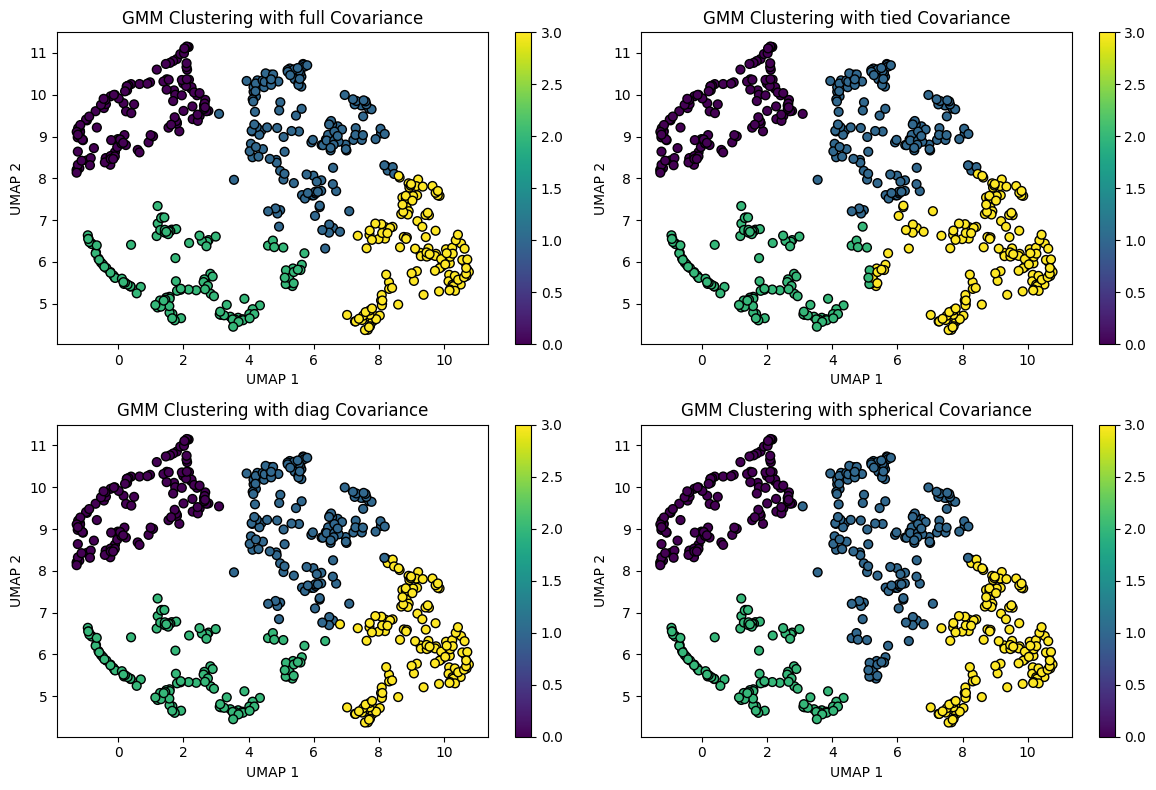

In [21]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
model_umap_color_mm = reducer.fit_transform(df_color_mm_cl)

# Clustering con GMM
n_components = 4
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_mm_umap = {
    cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
    for cov_type in covariance_types
}

# Entrenar modelos
for cov_type, gmm_model in gmm_models_mm_umap.items():
    gmm_model.fit(model_umap_color_mm)

# Obtener matrices de covarianza
covariances_mm_umap = {
    cov_type: gmm_model.covariances_ for cov_type, gmm_model in gmm_models_mm_umap.items()
}

# Obtener predicciones
predictions_mm_umap = {
    cov_type: gmm_model.predict(model_umap_color_mm) for cov_type, gmm_model in gmm_models_mm_umap.items()
}

# Graficar
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    plt.subplot(2, 2, i)
    plt.scatter(
        model_umap_color_mm[:, 0], model_umap_color_mm[:, 1],
        c=predictions_mm_umap[cov_type],
        cmap='viridis', edgecolors='k', s=40
    )
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

    print(f'Covariance Matrix ({cov_type} - Component 0):\n{covariances_mm_umap[cov_type][0]}')

plt.tight_layout()
plt.show()

In [22]:
df_color_mm['gmm_umap_full'] = predictions_mm_umap['full']
df_color_mm['gmm_umap_tied'] = predictions_mm_umap['tied']
df_color_mm['gmm_umap_diag'] = predictions_mm_umap['diag']
df_color_mm['gmm_umap_spherical'] = predictions_mm_umap['spherical']

contingency_umap_full = pd.crosstab(df_color_mm['label'], df_color_mm['gmm_umap_full'], rownames=['Label'], colnames=['Cluster (UMAP - full)'])
contingency_umap_tied = pd.crosstab(df_color_mm['label'], df_color_mm['gmm_umap_tied'], rownames=['Label'], colnames=['Cluster (UMAP - tied)'])
contingency_umap_diag = pd.crosstab(df_color_mm['label'], df_color_mm['gmm_umap_diag'], rownames=['Label'], colnames=['Cluster (UMAP - diag)'])
contingency_umap_spherical = pd.crosstab(df_color_mm['label'], df_color_mm['gmm_umap_spherical'], rownames=['Label'], colnames=['Cluster (UMAP - spherical)'])

print("Contingency Table for UMAP + Full Covariance:")
print(contingency_umap_full)

print("\nContingency Table for UMAP + Tied Covariance:")
print(contingency_umap_tied)

print("\nContingency Table for UMAP + Diagonal Covariance:")
print(contingency_umap_diag)

print("\nContingency Table for UMAP + Spherical Covariance:")
print(contingency_umap_spherical)



Contingency Table for UMAP + Full Covariance:
Cluster (UMAP - full)   0   1   2   3
Label                                
higher                 54  72  59  83
smaller                72  84  65  48

Contingency Table for UMAP + Tied Covariance:
Cluster (UMAP - tied)   0   1   2   3
Label                                
higher                 55  65  52  96
smaller                72  78  63  56

Contingency Table for UMAP + Diagonal Covariance:
Cluster (UMAP - diag)   0   1   2   3
Label                                
higher                 55  69  59  85
smaller                72  78  66  53

Contingency Table for UMAP + Spherical Covariance:
Cluster (UMAP - spherical)   0   1   2   3
Label                                     
higher                      54  82  47  85
smaller                     72  90  58  49


In [23]:
# Calcular silueta para cada tipo de covarianza usando UMAP
for cov_type in covariance_types:
    labels = predictions_mm_umap[cov_type]
    score = silhouette_score(model_umap_color_mm, labels)
    print(f"Silhouette Score (UMAP + GMM {cov_type}): {score:.4f}")

Silhouette Score (UMAP + GMM full): 0.4920
Silhouette Score (UMAP + GMM tied): 0.4854
Silhouette Score (UMAP + GMM diag): 0.4960
Silhouette Score (UMAP + GMM spherical): 0.4937


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Covariance Matrix (full - Component 0):
[[2.09997509 0.79618134]
 [0.79618134 0.8548328 ]]
Covariance Matrix (tied - Component 0):
[2.60938654 0.05506456]
Covariance Matrix (diag - Component 0):
[2.19658088 0.87497454]
Covariance Matrix (spherical - Component 0):
1.5443724912941974


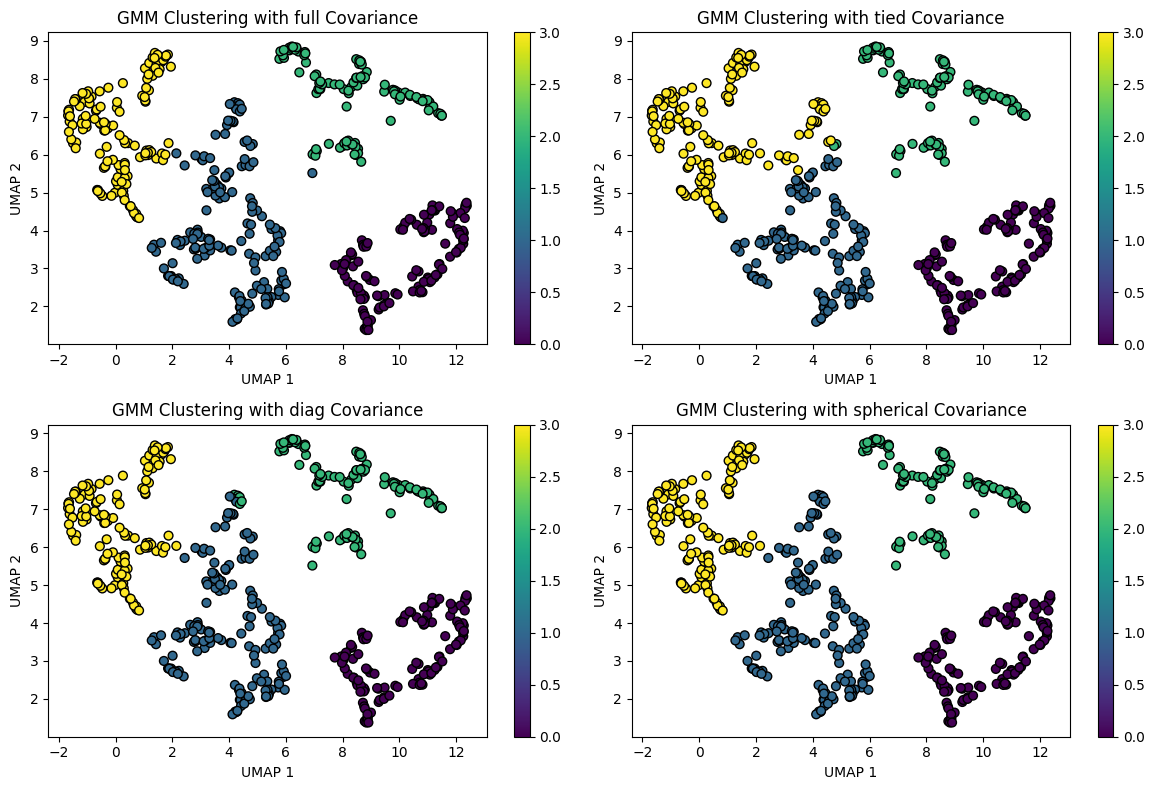

In [24]:
reducer = umap.UMAP(n_neighbors=10, n_components=2, random_state=42)
model_umap_color_z = reducer.fit_transform(df_color_z_cl)

# Clustering con GMM
n_components = 4
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_z_umap = {
    cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
    for cov_type in covariance_types
}

# Entrenar modelos
for cov_type, gmm_model in gmm_models_z_umap.items():
    gmm_model.fit(model_umap_color_z)

# Obtener matrices de covarianza
covariances_z_umap = {
    cov_type: gmm_model.covariances_ for cov_type, gmm_model in gmm_models_z_umap.items()
}

# Obtener predicciones
predictions_z_umap = {
    cov_type: gmm_model.predict(model_umap_color_z) for cov_type, gmm_model in gmm_models_z_umap.items()
}

# Graficar
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    plt.subplot(2, 2, i)
    plt.scatter(
        model_umap_color_z[:, 0], model_umap_color_z[:, 1],
        c=predictions_z_umap[cov_type],
        cmap='viridis', edgecolors='k', s=40
    )
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

    print(f'Covariance Matrix ({cov_type} - Component 0):\n{covariances_z_umap[cov_type][0]}')

plt.tight_layout()
plt.show()

In [25]:
df_color_z['gmm_umap_full'] = predictions_z_umap['full']
df_color_z['gmm_umap_tied'] = predictions_z_umap['tied']
df_color_z['gmm_umap_diag'] = predictions_z_umap['diag']
df_color_z['gmm_umap_spherical'] = predictions_z_umap['spherical']

contingency_umap_full = pd.crosstab(df_color_z['label'], df_color_z['gmm_umap_full'], rownames=['Label'], colnames=['Cluster (UMAP - full)'])
contingency_umap_tied = pd.crosstab(df_color_z['label'], df_color_z['gmm_umap_tied'], rownames=['Label'], colnames=['Cluster (UMAP - tied)'])
contingency_umap_diag = pd.crosstab(df_color_z['label'], df_color_z['gmm_umap_diag'], rownames=['Label'], colnames=['Cluster (UMAP - diag)'])
contingency_umap_spherical = pd.crosstab(df_color_z['label'], df_color_z['gmm_umap_spherical'], rownames=['Label'], colnames=['Cluster (UMAP - spherical)'])

print("Contingency Table for UMAP + Full Covariance:")
print(contingency_umap_full)

print("\nContingency Table for UMAP + Tied Covariance:")
print(contingency_umap_tied)

print("\nContingency Table for UMAP + Diagonal Covariance:")
print(contingency_umap_diag)

print("\nContingency Table for UMAP + Spherical Covariance:")
print(contingency_umap_spherical)

Contingency Table for UMAP + Full Covariance:
Cluster (UMAP - full)   0   1   2   3
Label                                
higher                 55  80  47  86
smaller                72  88  58  51

Contingency Table for UMAP + Tied Covariance:
Cluster (UMAP - tied)   0   1   2   3
Label                                
higher                 55  65  50  98
smaller                72  75  58  64

Contingency Table for UMAP + Diagonal Covariance:
Cluster (UMAP - diag)   0   1   2   3
Label                                
higher                 55  77  50  86
smaller                72  82  63  52

Contingency Table for UMAP + Spherical Covariance:
Cluster (UMAP - spherical)   0   1   2   3
Label                                     
higher                      55  79  48  86
smaller                     72  87  58  52


In [26]:
# Calcular silueta para cada tipo de covarianza usando UMAP
for cov_type in covariance_types:
    labels = predictions_z_umap[cov_type]
    score = silhouette_score(model_umap_color_z, labels)
    print(f"Silhouette Score (UMAP + GMM {cov_type}): {score:.4f}")

Silhouette Score (UMAP + GMM full): 0.5224
Silhouette Score (UMAP + GMM tied): 0.5065
Silhouette Score (UMAP + GMM diag): 0.5207
Silhouette Score (UMAP + GMM spherical): 0.5240


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


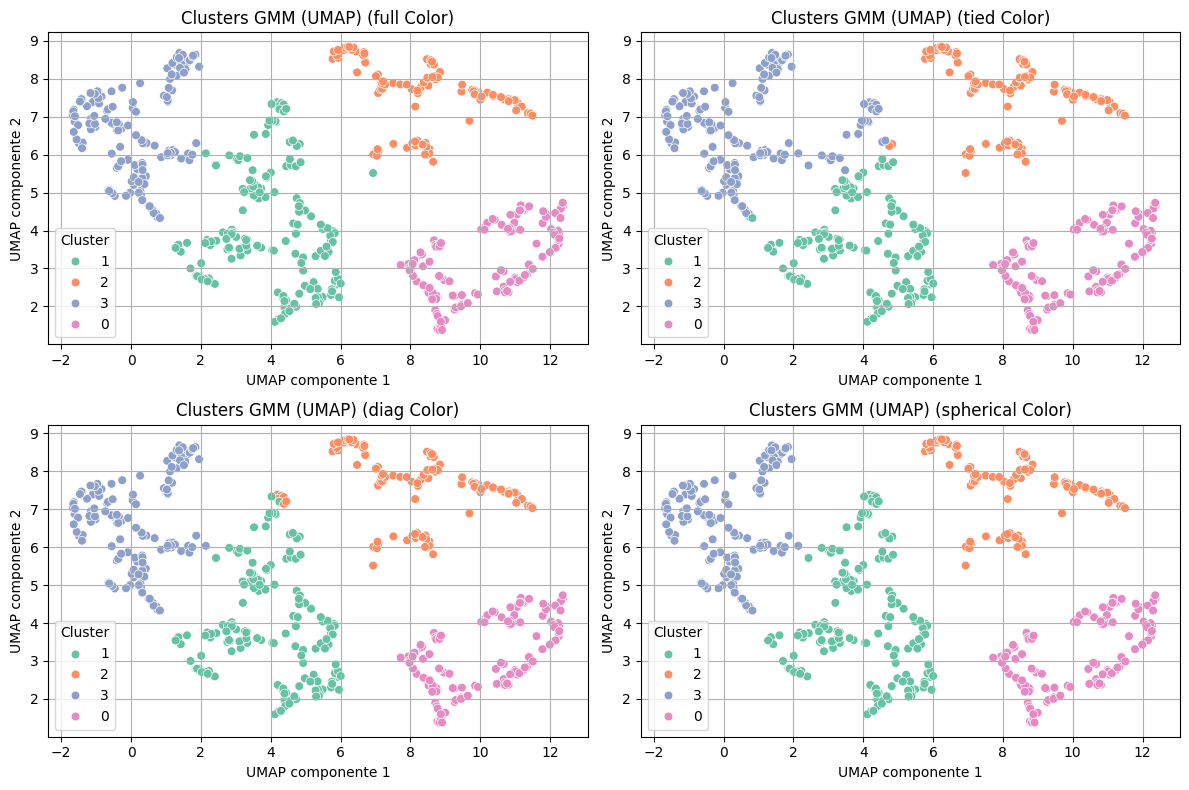

In [29]:
import seaborn as sns
# Paso 1: UMAP
reducer = umap.UMAP(n_neighbors=10, n_components=2, random_state=42)
embedding = reducer.fit_transform(df_color_z_cl)

# Paso 2: GMM con diferentes covarianzas
n_components = 4
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_z_umap = {
    cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42).fit(embedding)
    for cov_type in covariance_types
}

# Paso 3: Predicciones
predictions_z_umap = {
    cov_type: model.predict(embedding)
    for cov_type, model in gmm_models_z_umap.items()
}

# Paso 4: Visualización
plt.figure(figsize=(12, 8))

for i, cov_type in enumerate(covariance_types, 1):
    plt.subplot(2, 2, i)
    
    clusters = predictions_z_umap[cov_type]
    df_plot = pd.DataFrame({
        'UMAP 1': embedding[:, 0],
        'UMAP 2': embedding[:, 1],
        'Cluster': clusters.astype(str)
    })
    
    palette = sns.color_palette("Set2", n_colors=n_components)
    
    sns.scatterplot(
        data=df_plot,
        x='UMAP 1',
        y='UMAP 2',
        hue='Cluster',
        palette=palette,
        edgecolor='white',
        s=40,
        alpha=1,
        legend='full'
    )
    
    plt.title(f'Clusters GMM (UMAP) ({cov_type} Color)')
    plt.xlabel('UMAP componente 1')
    plt.ylabel('UMAP componente 2')
    plt.grid(True)

plt.tight_layout()
plt.show()